In [1]:
# ECE60146 HW9
# Zhengxin Jiang
# jiang839

import numpy as np
import os
import matplotlib.pyplot as plt
from PIL import Image
from pycocotools.coco import COCO
import seaborn as sn 
import random
import json
import math

import torch
import torch.nn as nn 
import torch.nn.functional as F 
import torchvision
import torchvision.transforms as tvt
from torch.utils.data import DataLoader
from pytorch_model_summary import summary


import ViTHelper

import cv2

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [4]:
# Function for preparing the training data
def prepData(root):
    
    rawDataDir = os.path.join(root, 'train2014').replace("\\","/")
    hwDataDir = os.path.join(root, 'hw9').replace("\\","/")
    
    coco = COCO('{}/annotations/instances_train2014.json'.format(rawDataDir)) 
    
    catIds = coco.getCatIds(catNms=['airplane','bus','cat','dog','pizza'])
    
    for catCount,catId in enumerate(catIds):
        
        ImgIds = coco.getImgIds(catIds=catId)
        random.shuffle(ImgIds)
        
        imgCount = 0
        for i,imgId in enumerate(ImgIds):
            
            coco_img = coco.loadImgs(imgId)[0]
            annId = coco.getAnnIds(imgIds=coco_img['id'], catIds=catId, iscrowd=None)
            anns = coco.loadAnns(annId)
            
            # check if the image is valid
            is_valid = 0
            
            for ann in anns:
                if ann['area'] > 8000:
                    is_valid = 1
                    
            if is_valid==0:
                continue
            
            imgName = coco_img['file_name']
            img = Image.open(rawDataDir+'/'+imgName)
            
            if img.mode != "RGB":
                img = img.convert(mode="RGB")
            img = img.resize((64, 64), Image.BOX)
            
            
            # Save training and validation images
            if imgCount<1500:
                
                imgNewName = str(catCount*1500+imgCount) + '.jpg'
                fp = open('{}/train/{}'.format(hwDataDir, imgNewName), 'w')
                img.save(fp)
                
            elif imgCount<2000:
                
                imgNewName = str(catCount*500+imgCount-1500) + '.jpg'
                fp = open('{}/val/{}'.format(hwDataDir, imgNewName), 'w')
                img.save(fp)
                
            else:
                break
                
            imgCount += 1
                
    return

# The Dataset class for hw9
class hwDataset(torch.utils.data.Dataset):
    
    def __init__(self, root, tasktype):
        super().__init__()
        if tasktype == 'training':
            self.root = os.path.join(root, 'hw9', 'train').replace("\\","/")  
            self.classsize = 1500
        if tasktype == 'validation':
            self.root = os.path.join(root, 'hw9', 'val').replace("\\","/")
            self.classsize = 500
        
    def __len__(self):
        return len(os.listdir(self.root))
        
    def __getitem__(self, index):
        name = str(index)+'.jpg'
        img = Image.open(os.path.join(self.root, name))
        
        tr = tvt.Compose([
            tvt.ToTensor(),
            tvt.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
        ])
        
        img_tensor = tr(img)
        
        return img_tensor, index//self.classsize


# Network of hw9
class ViT(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.conv = nn.Conv2d(3, 1, 2, 2, 0, bias=False)
        self.encoder = ViTHelper.MasterEncoder(17, 64, 2, 2)
        self.fc = nn.Linear(64, 5)
        
    def forward(self, x):
        x = self.conv(x)
        
        ## construct input sequence
        x = x.view(x.shape[0], 16, 64)
        class_token = nn.Parameter(torch.zeros(x.shape[0],1,64)).to(device)
        x = torch.cat((class_token, x), 1)
        
        ## pass through encoder
        x = self.encoder(x)
        
        ## MLP head
        x = self.fc(x[:,0,:])
        
        return x

# Training function    
def netTraining(saving_path, net, train_data_loader, epochs):
    
    net = net.to(device)
    criterion = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(net.parameters(), lr=1e-3, betas=(0.9, 0.99))

    loss_list = []
    for epoch in range(epochs):
        running_loss = 0.0
        for i, data in enumerate(train_data_loader):
            inputs, labels = data
            inputs = inputs.to(device)
            labels = labels.to(device)
            optimizer.zero_grad()
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            if (i+1) % 100 == 0:
                print("[ epoch : %d, batch : %5d] loss : %.3f" % (epoch + 1, i + 1, running_loss / 100))
                loss_list.append(running_loss / 100)
                running_loss = 0.0
    
    # saving the learned parameters
    torch.save(net.state_dict(), saving_path)
    return loss_list


def validation(net, val_data_loader):
    
    cm = torch.zeros(5,5)
    true_count = 0
    
    # no grad for inference
    with torch.no_grad():
        for i, data in enumerate(val_data_loader):
            inputs, labels = data
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = net(inputs)
            
            # The predicted labels
            max_vals, predicted_labels = torch.max(outputs, 1)
            
            for i in range(len(labels)):
                cm[labels[i]][predicted_labels[i]] += 1
                if labels[i] == predicted_labels[i]:
                    true_count += 1
        
    return cm, true_count/2500


In [2]:
root = 'D:/coco'

In [91]:
prepData(root)

loading annotations into memory...
Done (t=10.42s)
creating index...
index created!


In [12]:
traindataset = hwDataset(root, 'training')
train_data_loader = DataLoader(traindataset, batch_size=30, num_workers=0, shuffle=True)

In [13]:
net = ViT()
epochs = 25
saving_path = 'vit_.pth'

loss = netTraining(saving_path, net, train_data_loader, epochs)

[ epoch : 1, batch :   100] loss : 1.632
[ epoch : 1, batch :   200] loss : 1.478
[ epoch : 2, batch :   100] loss : 1.199
[ epoch : 2, batch :   200] loss : 1.278
[ epoch : 3, batch :   100] loss : 0.936
[ epoch : 3, batch :   200] loss : 1.000
[ epoch : 4, batch :   100] loss : 0.658
[ epoch : 4, batch :   200] loss : 0.754
[ epoch : 5, batch :   100] loss : 0.423
[ epoch : 5, batch :   200] loss : 0.529
[ epoch : 6, batch :   100] loss : 0.285
[ epoch : 6, batch :   200] loss : 0.405
[ epoch : 7, batch :   100] loss : 0.219
[ epoch : 7, batch :   200] loss : 0.313
[ epoch : 8, batch :   100] loss : 0.165
[ epoch : 8, batch :   200] loss : 0.239
[ epoch : 9, batch :   100] loss : 0.173
[ epoch : 9, batch :   200] loss : 0.263
[ epoch : 10, batch :   100] loss : 0.137
[ epoch : 10, batch :   200] loss : 0.209
[ epoch : 11, batch :   100] loss : 0.128
[ epoch : 11, batch :   200] loss : 0.190
[ epoch : 12, batch :   100] loss : 0.095
[ epoch : 12, batch :   200] loss : 0.160
[ epoch : 

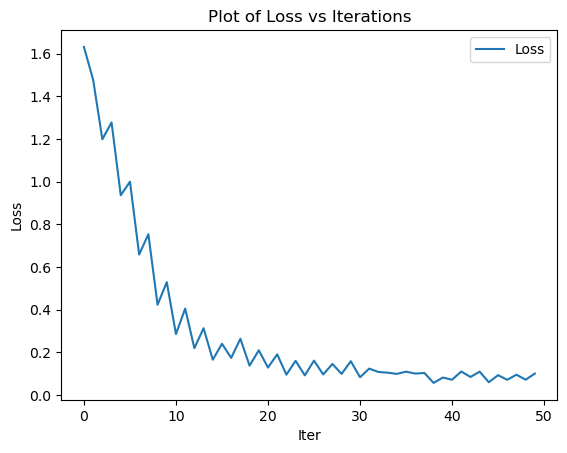

In [14]:
## plot the training loss
plt.plot(loss, label='Loss')
plt.legend()
plt.title("Plot of Loss vs Iterations")
plt.xlabel('Iter')
plt.ylabel('Loss')
plt.show()

In [11]:
# net = ViT()
# net = net.to(device)
# ## load trained parameters 
# net.load_state_dict(torch.load('vit_.pth', map_location=torch.device(device))) 

valdataset = hwDataset(root, 'validation')
val_data_loader = DataLoader(valdataset, batch_size=32, num_workers=0, shuffle=False)

confusion_matrix, acc = validation(net, val_data_loader)


<Axes: title={'center': 'Confusion Matrix of Validation, acc=0.5072'}>

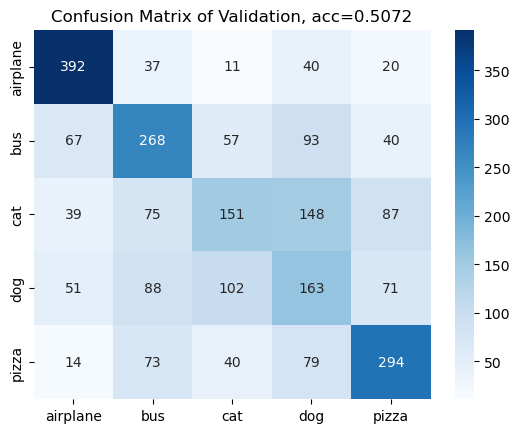

In [10]:
plt.figure()
plt.title("Confusion Matrix of Validation, acc="+str(acc)) 
sn.heatmap(confusion_matrix, annot=True, cmap="Blues",xticklabels=['airplane','bus','cat','dog','pizza'], yticklabels=['airplane','bus','cat','dog','pizza'], fmt='.3g')